In [1]:
# Wyłączenie ostrzerzeń w ramach skryptu
options(warn = -1)

# Zimportowanie bibliotek
library(tidyverse)
# - KNN
library(class)
library(caret)
# - Bayes
library(ROCR)
library(e1071)
# - Drzewa klasyfikacyjne
library(rpart)
library(rpart.plot)
library(tree)
# - Drzewa losowe
library(randomForest)
# - XGBoost
library(xgboost)
# - SVM

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin



Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice


In [2]:
# Zaladowanie pakietu dummies
library(dummies)

# Zaimportowanie zbioru danych z podaniem typów kolumn do zmiennej srodowiskowej "Wesbrook"
Wesbrook <- read_csv('http://jolej.linuxpl.info/Wesbrook.csv', col_types = "ifncfffffffffcffffinnnnnnnfnnnn")

# Wyswietlenie podgladu danych przechowywanych w obiekcie "Wesbrook"
glimpse(Wesbrook)

dummies-1.5.6 provided by Decision Patterns




Rows: 2,770
Columns: 31
$ ID       <int> 88, 152, 157, 158, 159, 160, 169, 206, 209, 218, 231, 238, 27…
$ WESBROOK <fct> Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, N, Y, Y, N, Y, N, N, N, Y…
$ TOTLGIVE <dbl> 24728, 23500, 3000, 7600, 20000, 7829, 2476, 5000, 13611, 685…
$ INDUPDT  <chr> "10/02/1995", "07/21/1997", "08/22/1994", "12/21/1996", "05/0…
$ GRADYR1  <fct> 1960, 1988, 1949, NA, 1958, NA, NA, 1993, 1937, 1990, 1958, N…
$ FACULTY1 <fct> CO, PO, AP, NA, LA, NA, NA, PO, AR, PO, CO, NA, AP, LA, LA, F…
$ DEPT1    <fct> CO, PO, AP, NA, LA, NA, NA, PO, AR, PO, CO, NA, AP, LA, LA, F…
$ MAJOR1   <fct> NA, NA, CIVL, NA, NA, NA, NA, NA, NA, NA, NA, NA, GEOE, NA, N…
$ PARENT   <fct> Y, N, Y, N, Y, Y, N, Y, Y, Y, Y, Y, N, N, N, N, N, N, N, N, N…
$ CHILD    <fct> Y, N, N, N, Y, N, N, Y, Y, N, N, N, N, N, N, N, N, N, N, N, N…
$ SPOUSE   <fct> Y, Y, Y, Y, Y, N, Y, Y, Y, Y, Y, Y, N, N, Y, Y, N, Y, Y, N, Y…
$ SEX      <fct> M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, M, F, F, M…
$ MARITAL  <fct>

In [3]:
#################
# TRESC ZADANIA #
#################

# Dla 6 modeli przy ich wykorzystaniu zbudowac i sparametryzowac model klasyfikacyjny:
# 1. K-najblizszych sasiadow
# 2. Naiwnego klasyfikatora Bayesa
# 3. Drzew klasyfikacyjnych
# 4. Lasow Losowych (Random Forest)
# 5. Algorytmu XGBoost
# 6. Metody SVM

# Dla kazdego z modeli wykonac ewaluacje z wykorzystaniem:
# - macierzy pomylek
# - krzywej ROC
# - wspolczynnika AUC

# Dla kazdego z modeli wykonac walidacje krzyzowa k-krotna oraz losowa

# Sformuowac wnioski

In [4]:
########################
# Przygotowanie danych #
########################

# Sprawdzenie ile jest brakujacych wartosci
print(sort(colSums(is.na(Wesbrook)), decreasing = TRUE))
rows_with_na <- Wesbrook[rowSums(is.na(Wesbrook)) > 0, ]
print(rows_with_na)
print(nrow(rows_with_na))

# Usuniecie kolumny DEPT1 - to powielenie kolumny FACULTY1
Wesbrook <- Wesbrook %>% select(-DEPT1)

# Usuniecie kolumny INDUPDT - zbedna dana
Wesbrook <- Wesbrook %>% select(-INDUPDT)

# Usuniecie kolumny EA - zbedna dana
Wesbrook <- Wesbrook %>% select(-EA)

# Usuniecie kolumny BIGBLOCK - nikt nie wzial udzialu w tym programie
Wesbrook <- Wesbrook %>% select(-BIGBLOCK)

# Usuniecie rekordow, ktore maja GRADYR1 jako NA
Wesbrook <- Wesbrook %>%
  filter(!is.na(GRADYR1))

# Sprawdzenie wartosci dla kolumny MARITAL wraz z brakujacymi wartosciami
print(table(Wesbrook$MARITAL, useNA = "ifany"))

# Dla braku statusu malzenskiego przypisac wartosc "S"
Wesbrook$MARITAL[is.na(Wesbrook$MARITAL)] <- "S"

# Dla braku kodu przedmiotu MAJOR1 przypisac wartosc "TBS" - to be specified
Wesbrook$MAJOR1 <- factor(Wesbrook$MAJOR1, levels = c(levels(Wesbrook$MAJOR1), "TBS"))
Wesbrook$MAJOR1[is.na(Wesbrook$MAJOR1)] <- "TBS"

# Ustawienie brakujacych wartosci sredniego dochodu AVE_INC jako srednia ze wszystkich wartosci
Wesbrook$AVE_INC[is.na(Wesbrook$AVE_INC)] <- mean(Wesbrook$AVE_INC, na.rm = TRUE)

# Ustawienie brakujacych wartosci odchylenia standardowego SD_INC jako srednia ze wszystkich wartosci
Wesbrook$SD_INC[is.na(Wesbrook$SD_INC)] <- mean(Wesbrook$SD_INC, na.rm = TRUE)

# Usuniecie pozostalych rekordow z brakujacymi wartosciami
Wesbrook <- Wesbrook %>% drop_na()

# Ponowsne sprawdzenie ile jest brakujacych wartosci
print(sort(colSums(is.na(Wesbrook)), decreasing = TRUE))
rows_with_na <- Wesbrook[rowSums(is.na(Wesbrook)) > 0, ]
print(rows_with_na)
print(nrow(rows_with_na))

# Zapisanie kopii zbioru dla jego przywracania
Wesbrook_backup <- Wesbrook

  MAJOR1  MARITAL  GRADYR1 FACULTY1    DEPT1 FRSTYEAR  AVE_INC   SD_INC 
    1964     1815      947      947      947      947       71       71 
CNDN_PCT MOV_DWEL  HH_1PER  HH_2PER  HH_3PER HH_45PER DWEL_VAL  ENG_PCT 
      29       28       28       28       28       28       28       28 
 OWN_PCT     PROV       EA  INDUPDT       ID WESBROOK TOTLGIVE   PARENT 
      28       17       13       12        0        0        0        0 
   CHILD   SPOUSE      SEX FACSTAFF  ATHLTCS BIGBLOCK OTHERACT 
       0        0        0        0        0        0        0 
# A tibble: 2,488 × 31
      ID WESBROOK TOTLGIVE INDUPDT    GRADYR1 FACULTY1 DEPT1 MAJOR1 PARENT CHILD
   <int> <fct>       <dbl> <chr>      <fct>   <fct>    <fct> <fct>  <fct>  <fct>
 1    88 Y           24728 10/02/1995 1960    CO       CO    NA     Y      Y    
 2   152 Y           23500 07/21/1997 1988    PO       PO    NA     N      N    
 3   158 Y            7600 12/21/1996 NA      NA       NA    NA     N      N    
 4   1

In [5]:
##################################
# 1. K-najblizszych sasiadow     #
##################################

In [6]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu modelu
rm(list = setdiff(ls(), "Wesbrook_backup"))

# Przywrocenie zbioru z kopii
Wesbrook <- Wesbrook_backup

### Normalizacja zmiennych numerycznych

# Funkcja normalizujaca metoda min - max
normalize <- function(x) {
  if (min(x) == max(x)) {
    return(rep(0, length(x)))
  } else {
    return((x - min(x)) / (max(x) - min(x)))
  }
}

# Zastosowanie funkcji normalizujacej dla kazdej zmiennej numerycznej
Wesbrook <- Wesbrook %>%
  mutate(across(where(is.numeric), normalize))

### Kodowanie zero jedynkowe zmiennych typu factor

# Zmiana obiektu z tibble na data.frame
Wesbrook <- data.frame(Wesbrook)

# Wydzielenie ze zbioru zmiennej objasnianej
Wesbrook_labels <- Wesbrook %>% select(WESBROOK)
Wesbrook <- Wesbrook %>% select(-WESBROOK)

# Podglad etykiet zmiennych
colnames(Wesbrook)

# Utworzenie ramki danych
Wesbrook<-as.data.frame(Wesbrook)

# Utworzenie zmiennych sztucznych dla zmiennych czynnikowych
factor_columns <- names(Wesbrook)[sapply(Wesbrook, is.factor)]
Wesbrook <- dummy.data.frame(data = Wesbrook, factor_columns, sep = "_")

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(Wesbrook), round(nrow(Wesbrook) * .75), replace = FALSE)
wesbrook_train <- Wesbrook[sample_index,]
wesbrook_test <- Wesbrook[-sample_index,]

# Powt?rzenie operacji dla zmiennej objasnianej heartDisease
wesbrook_train_labels <- as.factor(Wesbrook_labels[sample_index,])
wesbrook_test_labels <- as.factor(Wesbrook_labels[-sample_index,])

# Wymuszenie takich samych poziomów dla obu zbiorów etykiet
# Dla zmiennej numerycznej objasniajacej poziomy moga sie roznic przez rozne
# kombinacje w kategoriach, brakujace w zbiorze testowym lub rozny ich porzadek 
# levels(wesbrook_test_labels) <- levels(wesbrook_train_labels)


[1] "ID"       "TOTLGIVE" "GRADYR1"  "FACULTY1" "MAJOR1"   "PARENT"  
 [7] "CHILD"    "SPOUSE"   "SEX"      "MARITAL"  "FACSTAFF" "ATHLTCS" 
[13] "OTHERACT" "FRSTYEAR" "MOV_DWEL" "HH_1PER"  "HH_2PER"  "HH_3PER" 
[19] "HH_45PER" "AVE_INC"  "DWEL_VAL" "PROV"     "CNDN_PCT" "ENG_PCT" 
[25] "OWN_PCT"  "SD_INC"

In [7]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Deklaracja wartosci k
k <- 15

### Budowa modelu KNN za pomoca funkcji knn() z pakietu class
wesbrook_pred1 <-
  knn(
    train = wesbrook_train,
    test = wesbrook_test,
    cl = wesbrook_train_labels,
    k = k
  )

# Podejrzenie pierwszych 6 elementów modelu
head(wesbrook_pred1)


[1] Y Y Y Y Y Y
Levels: Y N

Confusion Matrix and Statistics

          Reference
Prediction   Y   N
         Y  89  39
         N  96 228
                                          
               Accuracy : 0.7013          
                 95% CI : (0.6568, 0.7432)
    No Information Rate : 0.5907          
    P-Value [Acc > NIR] : 7.169e-07       
                                          
                  Kappa : 0.3517          
                                          
 Mcnemar's Test P-Value : 1.438e-06       
                                          
            Sensitivity : 0.4811          
            Specificity : 0.8539          
         Pos Pred Value : 0.6953          
         Neg Pred Value : 0.7037          
             Prevalence : 0.4093          
         Detection Rate : 0.1969          
   Detection Prevalence : 0.2832          
      Balanced Accuracy : 0.6675          
                                          
       'Positive' Class : Y               
                              

[1] 0.7585889

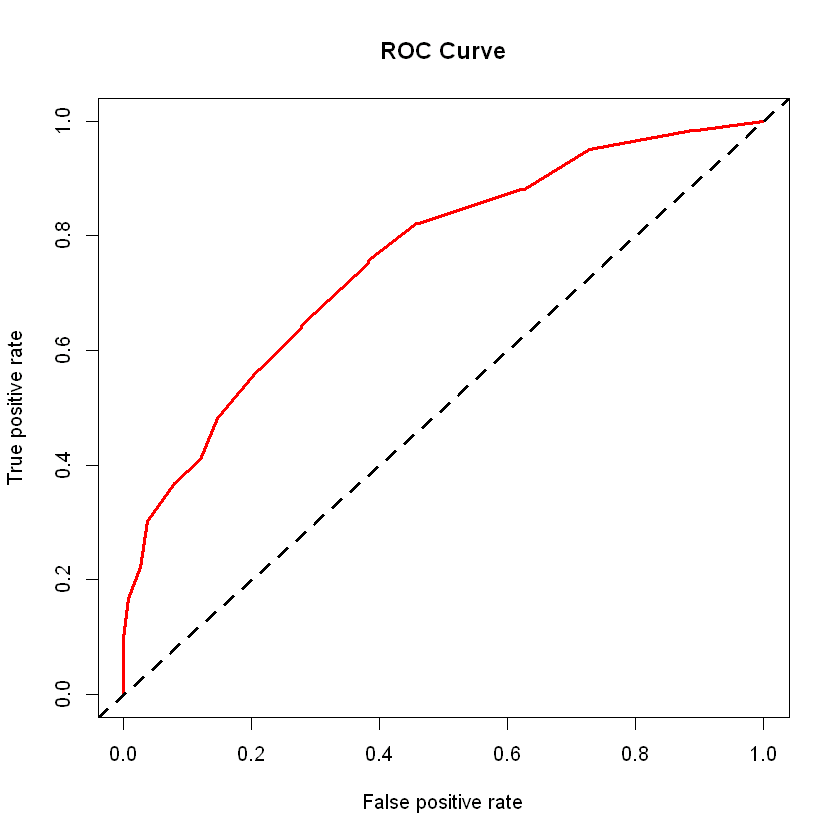

In [8]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wesbrook_pred1, wesbrook_test_labels)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Trening modelu KNN
knn_model <- train(
  x = wesbrook_train, 
  y = wesbrook_train_labels, 
  method = "knn", 
  trControl = trainControl(method = "cv", number = 10),
  tuneGrid = expand.grid(k = k)  # Określenie wartości k
)

wesbrook_pred_p <- predict(knn_model, wesbrook_test, type = "prob")

roc_pred <-
  prediction(
    predictions = wesbrook_pred_p[, "Y"],
    labels = wesbrook_test_labels
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Obliczanie pola pod krzywa ROC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wesbrook_auc <- unlist(slot(auc_perf,"y.values"))
wesbrook_auc


In [9]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
knn_cv <- train(
  x = wesbrook_train, 
  y = wesbrook_train_labels, 
  method = "knn", 
  trControl = trainControl(method = "cv", number = 10)
)
print(knn_cv)

### Walidacja krzyzowa losowa
knn_boot <- train(
  x = wesbrook_train, 
  y = wesbrook_train_labels, 
  method = "knn", 
  trControl = trainControl(method = "boot", number = 100)
)
print(knn_boot)


k-Nearest Neighbors 

1356 samples
 271 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1220, 1220, 1221, 1220, 1221, 1220, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.7433442  0.4598817
  7  0.7477614  0.4678626
  9  0.7529466  0.4783379

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.
k-Nearest Neighbors 

1356 samples
 271 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Bootstrapped (100 reps) 
Summary of sample sizes: 1356, 1356, 1356, 1356, 1356, 1356, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.7118252  0.3978292
  7  0.7237222  0.4215674
  9  0.7278074  0.4295137

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.


In [10]:
##################################
# 2. Naiwny klasyfikator Bayesa  #
##################################

In [11]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu modelu
rm(list = setdiff(ls(), "Wesbrook_backup"))

# Przywrocenie zbioru z kopii
Wesbrook <- Wesbrook_backup

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(Wesbrook), round(nrow(Wesbrook) * .75), replace = FALSE)
wesbrook_train <- Wesbrook[sample_index,]
wesbrook_test <- Wesbrook[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(Wesbrook, WESBROOK))),2)
round(prop.table(table(select(wesbrook_train, WESBROOK))),2)
round(prop.table(table(select(wesbrook_test, WESBROOK))),2)


WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

In [12]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

### Budowa modelu za pomoca funkcji naiveBayes() z pakietu e1071
wesbrook_mod <- naiveBayes(WESBROOK ~ ., data = wesbrook_train, laplace = 1)
wesbrook_mod

# Podstawienie danych testowych do modelu

wesbrook_pred <- predict(wesbrook_mod, wesbrook_test, type = "class")
head(wesbrook_pred)



Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
       Y        N 
0.410767 0.589233 

Conditional probabilities:
   ID
Y        [,1]     [,2]
  Y  60984.95 39675.91
  N 101814.70 65827.81

   TOTLGIVE
Y        [,1]       [,2]
  Y 6802.5727 13907.0770
  N  321.0839   611.3896

   GRADYR1
Y          1960        1988        1949        1958        1993        1937
  Y 0.036277603 0.009463722 0.018927445 0.020504732 0.007886435 0.009463722
  N 0.014840183 0.017123288 0.010273973 0.003424658 0.030821918 0.003424658
   GRADYR1
Y          1990        1971        1970        1964        1962        1965
  Y 0.004731861 0.022082019 0.020504732 0.014195584 0.028391167 0.026813880
  N 0.022831050 0.017123288 0.014840183 0.005707763 0.005707763 0.010273973
   GRADYR1
Y          1974        1972        1976        1975        1956        1967
  Y 0.017350158 0.022082019 0.020504732 0.018927445 0.034700315 0.02208

[1] Y Y Y Y Y Y
Levels: Y N

Confusion Matrix and Statistics

          Reference
Prediction   Y   N
         Y 153  41
         N  32 226
                                          
               Accuracy : 0.8385          
                 95% CI : (0.8013, 0.8712)
    No Information Rate : 0.5907          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6685          
                                          
 Mcnemar's Test P-Value : 0.3491          
                                          
            Sensitivity : 0.8270          
            Specificity : 0.8464          
         Pos Pred Value : 0.7887          
         Neg Pred Value : 0.8760          
             Prevalence : 0.4093          
         Detection Rate : 0.3385          
   Detection Prevalence : 0.4292          
      Balanced Accuracy : 0.8367          
                                          
       'Positive' Class : Y               
                              

[1] 0.9322806

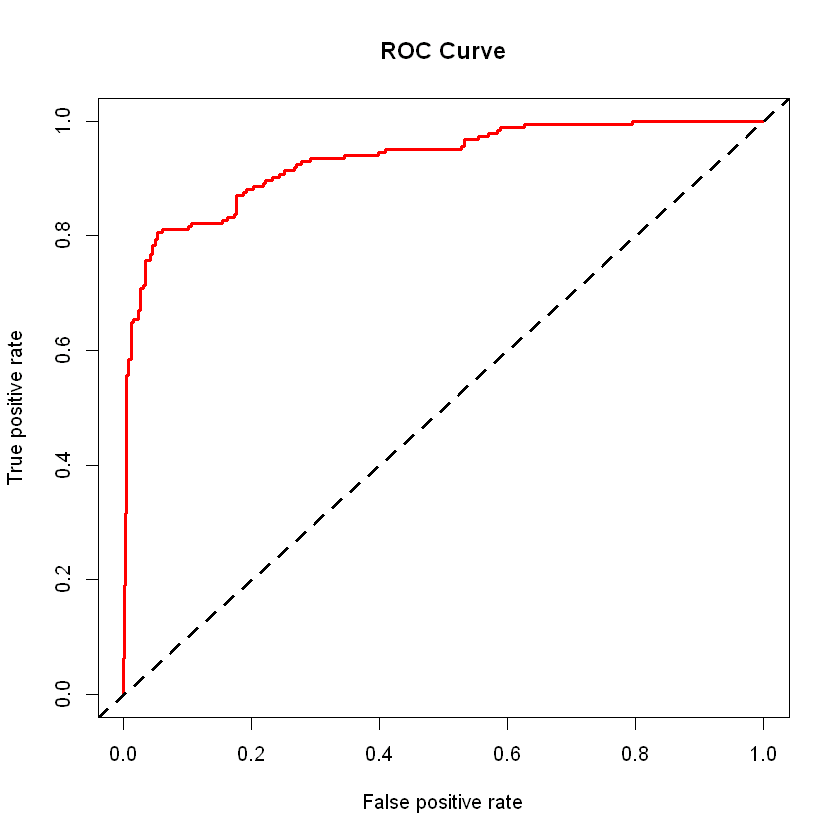

In [13]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wesbrook_pred, wesbrook_test$WESBROOK)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

wesbrook_pred_p <- predict(wesbrook_mod, wesbrook_test, type = "raw")

roc_pred <-
  prediction(
    predictions = wesbrook_pred_p[, "Y"],
    labels = wesbrook_test$WESBROOK
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wesbrook_auc <- unlist(slot(auc_perf,"y.values"))
wesbrook_auc


In [14]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
train_control <- trainControl(method = "cv", number = 100)
wesbrook_cv <- train(WESBROOK ~ ., data = Wesbrook, method = "naive_bayes", trControl = train_control)
print(wesbrook_cv)

### Walidacja krzyzowa losowa
n_iterations <- 10
results <- vector("list", n_iterations)

for (i in 1:n_iterations) {
  # Losowy podział danych na zbiór treningowy i testowy
  train_index <- createDataPartition(Wesbrook$WESBROOK, p = 0.75, list = FALSE)
  wesbrook_train <- Wesbrook[train_index,]
  wesbrook_test <- Wesbrook[-train_index,]
  
  # Budowa modelu
  wesbrook_mod <- naiveBayes(WESBROOK ~ ., data = wesbrook_train, laplace = 1)
  
  # Predykcja
  wesbrook_pred <- predict(wesbrook_mod, wesbrook_test, type = "class")
  
  # Obliczenie macierzy pomyłek
  cm <- confusionMatrix(wesbrook_pred, wesbrook_test$WESBROOK)
  results[[i]] <- cm$overall["Accuracy"]
}

# Średnia dokładność po 10 iteracjach
mean_accuracy <- mean(unlist(results))
print(mean_accuracy)


Naive Bayes 

1808 samples
  26 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Cross-Validated (100 fold) 
Summary of sample sizes: 1789, 1789, 1790, 1790, 1790, 1790, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE      0.5119900  0.1398757
   TRUE      0.5897265  0.0000000

Tuning parameter 'laplace' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were laplace = 0, usekernel = TRUE
 and adjust = 1.
[1] 0.8780488


In [15]:
##################################
# 3. Drzewa klasyfikacyjne       #
##################################

In [16]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu nastepnego modelu
rm(list = setdiff(ls(), "Wesbrook_backup"))

# Przywrocenie zbioru z kopii
Wesbrook <- Wesbrook_backup

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(Wesbrook), round(nrow(Wesbrook) * .75), replace = FALSE)
wesbrook_train <- Wesbrook[sample_index,]
wesbrook_test <- Wesbrook[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(Wesbrook, WESBROOK))),2)
round(prop.table(table(select(wesbrook_train, WESBROOK))),2)
round(prop.table(table(select(wesbrook_test, WESBROOK))),2)


WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

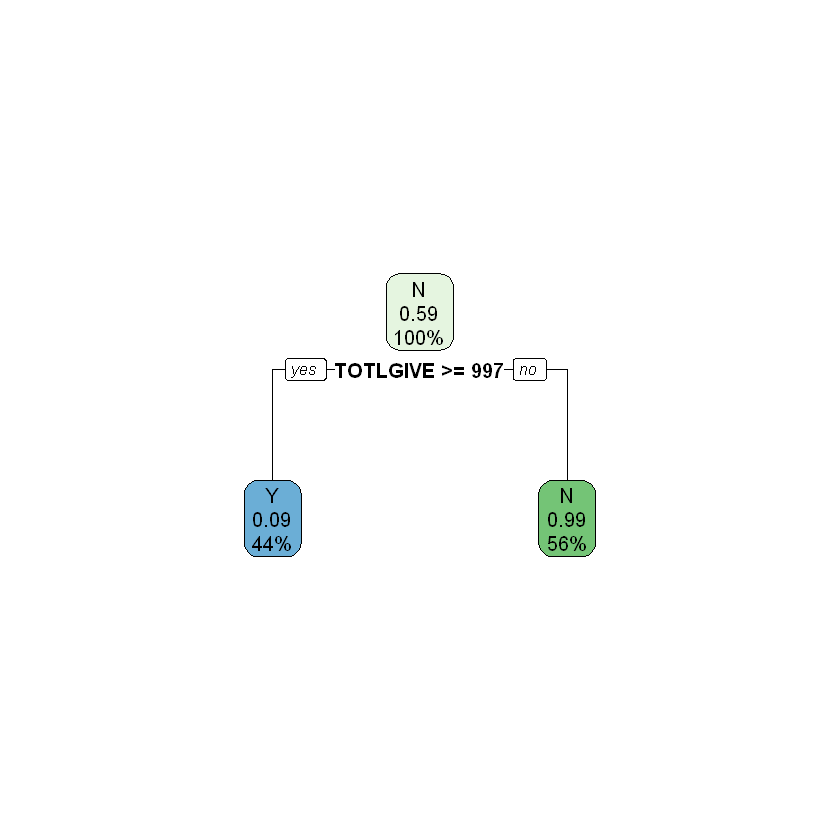

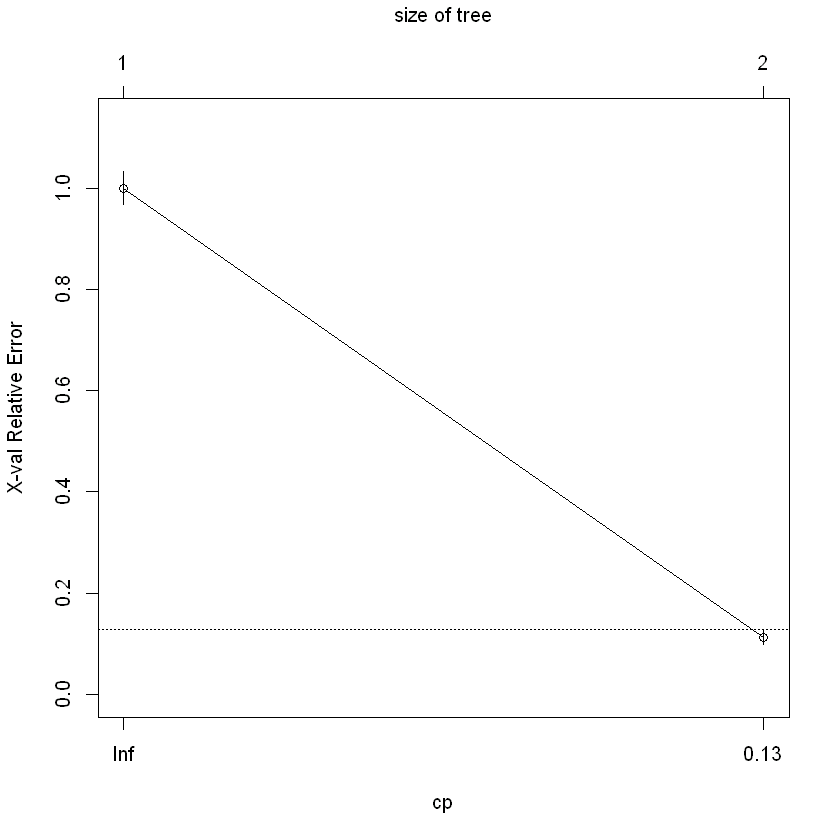

In [17]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Budowa modelu za pomoca funkcji rpart() z pakietu rpart ze wspolczynnikiem cp=0.02
wesbrook_mod <-
  rpart(
    WESBROOK ~ .,
    method = "class",
    data = wesbrook_train,
    cp = 0.02
  )

# Wygenerowanie wykresu drzewa
rpart.plot(wesbrook_mod)

# Wygenerowanie wykresu bledu w zaleznosci od wspolczynnika cp
plotcp(wesbrook_mod)

# Podstawienie do modelu wartosci ze zbioru testowego
wesbrook_pred <- predict(wesbrook_mod, wesbrook_test, type = "class")


Confusion Matrix and Statistics

          Reference
Prediction   Y   N
         Y 182  23
         N   3 244
                                          
               Accuracy : 0.9425          
                 95% CI : (0.9169, 0.9621)
    No Information Rate : 0.5907          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.883           
                                          
 Mcnemar's Test P-Value : 0.0001944       
                                          
            Sensitivity : 0.9838          
            Specificity : 0.9139          
         Pos Pred Value : 0.8878          
         Neg Pred Value : 0.9879          
             Prevalence : 0.4093          
         Detection Rate : 0.4027          
   Detection Prevalence : 0.4535          
      Balanced Accuracy : 0.9488          
                                          
       'Positive' Class : Y               
                              

,Y,N
1,0.9147157,0.08528428
2,0.9147157,0.08528428
3,0.9147157,0.08528428
4,0.9147157,0.08528428
5,0.9147157,0.08528428
6,0.9147157,0.08528428


[1] 0.9488207

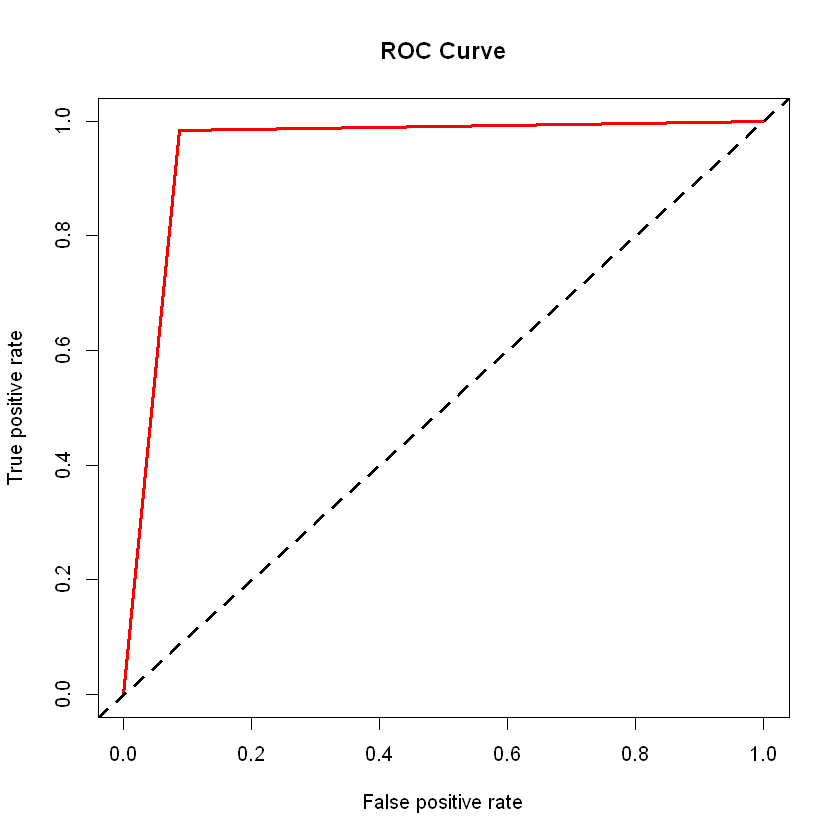

In [18]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wesbrook_pred, wesbrook_test$WESBROOK)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Predykcja wartosci prawdopodobienstw
wesbrook_pred_p <- predict(wesbrook_mod, wesbrook_test, type = "prob")
head(wesbrook_pred_p)

roc_pred <-
  prediction(
    predictions = wesbrook_pred_p[, "Y"],
    labels = wesbrook_test$WESBROOK
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wesbrook_auc <- unlist(slot(auc_perf,"y.values"))
wesbrook_auc


In [19]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
cv_model <- train(
  WESBROOK ~ ., 
  data = Wesbrook, 
  method = "rpart", 
  trControl = trainControl(method = "cv", number = 10)
)
print(cv_model)

### Walidacja krzyzowa losowa
random_cv_model <- train(
  WESBROOK ~ ., 
  data = Wesbrook, 
  method = "rpart", 
  trControl = trainControl(method = "boot", number = 100)  # 100 iteracji bootstrappingu
)
print(random_cv_model)


CART 

1808 samples
  26 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1628, 1626, 1628, 1626, 1628, 1627, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa    
  0.003369272  0.9457730  0.8885860
  0.004043127  0.9457730  0.8885860
  0.882749326  0.8025425  0.5321797

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.004043127.
CART 

1808 samples
  26 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Bootstrapped (100 reps) 
Summary of sample sizes: 1808, 1808, 1808, 1808, 1808, 1808, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa    
  0.003369272  0.9429974  0.8825732
  0.004043127  0.9440614  0.8848618
  0.882749326  0.7603486  0.4277933

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.004043127

In [20]:
##################################
# 4. Lasy Losowe (Random Forest) #
##################################

In [21]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu nastepnego modelu
rm(list = setdiff(ls(), "Wesbrook_backup"))

# Przywrocenie zbioru z kopii
Wesbrook <- Wesbrook_backup

# Usuniecie kolumn GRADYR1 oraz MAJOR1 - posiadaja za duzo kategorii
Wesbrook <- Wesbrook %>% select(-GRADYR1)
Wesbrook <- Wesbrook %>% select(-MAJOR1)

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(Wesbrook), round(nrow(Wesbrook) * .75), replace = FALSE)
wesbrook_train <- Wesbrook[sample_index,]
wesbrook_test <- Wesbrook[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(Wesbrook, WESBROOK))),2)
round(prop.table(table(select(wesbrook_train, WESBROOK))),2)
round(prop.table(table(select(wesbrook_test, WESBROOK))),2)


WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

In [22]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Budowa modelu za pomoca funkcji randomForest() z pakietu randomForest
wesbrook_mod <- randomForest(WESBROOK ~ ., data = wesbrook_train, ntrees=100)

wesbrook_pred <- predict(wesbrook_mod, wesbrook_test, type = "class")


Confusion Matrix and Statistics

          Reference
Prediction   Y   N
         Y 179  20
         N   6 247
                                          
               Accuracy : 0.9425          
                 95% CI : (0.9169, 0.9621)
    No Information Rate : 0.5907          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.8824          
                                          
 Mcnemar's Test P-Value : 0.01079         
                                          
            Sensitivity : 0.9676          
            Specificity : 0.9251          
         Pos Pred Value : 0.8995          
         Neg Pred Value : 0.9763          
             Prevalence : 0.4093          
         Detection Rate : 0.3960          
   Detection Prevalence : 0.4403          
      Balanced Accuracy : 0.9463          
                                          
       'Positive' Class : Y               
                              

,Y,N
1,0.982,0.018
2,0.954,0.046
3,0.838,0.162
4,0.856,0.144
5,0.948,0.052
6,0.822,0.178


[1] 0.9830347

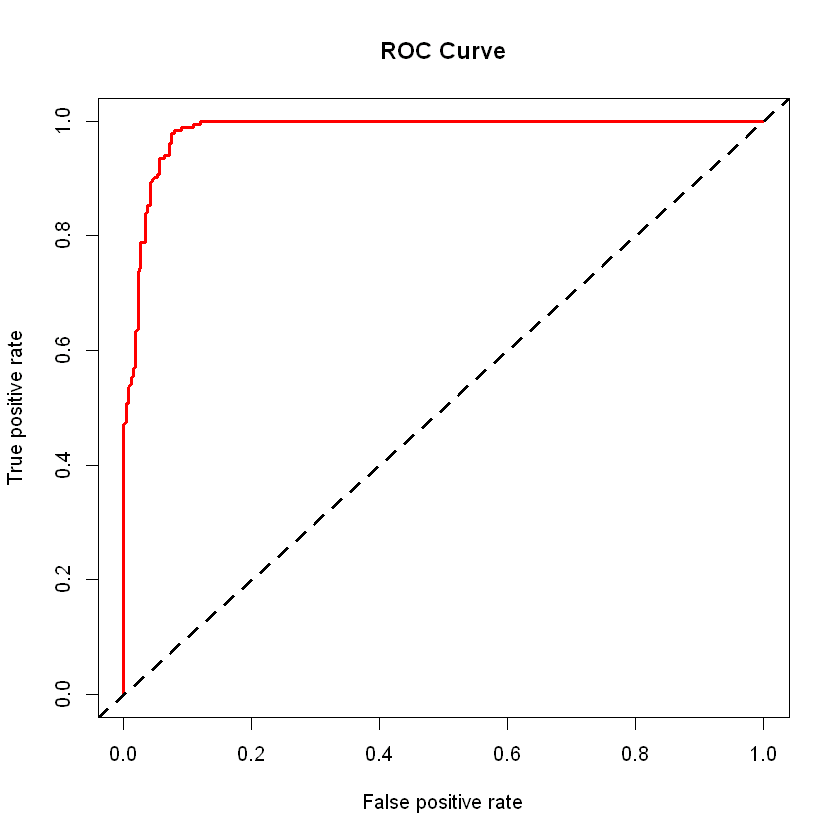

In [23]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wesbrook_pred, wesbrook_test$WESBROOK)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Predykcja wartosci prawdopodobienstw
wesbrook_pred_p <- predict(wesbrook_mod, wesbrook_test, type = "prob")
head(wesbrook_pred_p)

roc_pred <-
  prediction(
    predictions = wesbrook_pred_p[, "Y"],
    labels = wesbrook_test$WESBROOK
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wesbrook_auc <- unlist(slot(auc_perf,"y.values"))
wesbrook_auc


In [24]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
train_control <- trainControl(method = "cv", number = 5)
wesbrook_cv <- train(WESBROOK ~ ., data = Wesbrook, method = "rf", trControl = train_control)
print(wesbrook_cv)


### Walidacja krzyzowa losowa
train_control_random <- trainControl(method = "boot", number = 50)
wesbrook_random_cv <- train(WESBROOK ~ ., data = Wesbrook, method = "rf", trControl = train_control_random)
print(wesbrook_random_cv)

Random Forest 

1808 samples
  24 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1446, 1445, 1447, 1447, 1447 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9037463  0.8001799
  24    0.9496670  0.8969183
  46    0.9441345  0.8854530

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 24.
Random Forest 

1808 samples
  24 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Bootstrapped (50 reps) 
Summary of sample sizes: 1808, 1808, 1808, 1808, 1808, 1808, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8997904  0.7919552
  24    0.9510036  0.8997225
  46    0.9435235  0.8841917

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 24.


In [25]:
##################################
# 5. Algorytm XGBoost            #
##################################

In [26]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu nastepnego modelu
rm(list = setdiff(ls(), "Wesbrook_backup"))

# Przywrocenie zbioru z kopii
Wesbrook <- Wesbrook_backup

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(Wesbrook), round(nrow(Wesbrook) * .75), replace = FALSE)
wesbrook_train <- Wesbrook[sample_index,]
wesbrook_test <- Wesbrook[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(Wesbrook, WESBROOK))),2)
round(prop.table(table(select(wesbrook_train, WESBROOK))),2)
round(prop.table(table(select(wesbrook_test, WESBROOK))),2)


WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

In [27]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Budowa modelu za pomoca funkcji randomForest() z pakietu randomForest

modelLookup("xgbTree")

wesbrook_mod <- train(
  WESBROOK ~ .,
  data = wesbrook_train,
  metric = "Accuracy",
  method = "xgbTree",
  trControl = trainControl(method = "none"),
  tuneGrid = expand.grid(
    nrounds = 100,
    max_depth = 6,
    eta = 0.3,
    gamma = 0.01,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample = 1
  )
)

wesbrook_pred <- predict(wesbrook_mod, wesbrook_test, type = "raw")


,model,parameter,label,forReg,forClass,probModel
,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
1,xgbTree,nrounds,# Boosting Iterations,TRUE,TRUE,TRUE
2,xgbTree,max_depth,Max Tree Depth,TRUE,TRUE,TRUE
3,xgbTree,eta,Shrinkage,TRUE,TRUE,TRUE
4,xgbTree,gamma,Minimum Loss Reduction,TRUE,TRUE,TRUE
5,xgbTree,colsample_bytree,Subsample Ratio of Columns,TRUE,TRUE,TRUE
6,xgbTree,min_child_weight,Minimum Sum of Instance Weight,TRUE,TRUE,TRUE
7,xgbTree,subsample,Subsample Percentage,TRUE,TRUE,TRUE


Confusion Matrix and Statistics

          Reference
Prediction   Y   N
         Y 177  18
         N   8 249
                                          
               Accuracy : 0.9425          
                 95% CI : (0.9169, 0.9621)
    No Information Rate : 0.5907          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.882           
                                          
 Mcnemar's Test P-Value : 0.07756         
                                          
            Sensitivity : 0.9568          
            Specificity : 0.9326          
         Pos Pred Value : 0.9077          
         Neg Pred Value : 0.9689          
             Prevalence : 0.4093          
         Detection Rate : 0.3916          
   Detection Prevalence : 0.4314          
      Balanced Accuracy : 0.9447          
                                          
       'Positive' Class : Y               
                              

,Y,N
,<dbl>,<dbl>
1,0.9998710,0.0001289845
2,0.9997541,0.0002458692
3,0.9909930,0.0090070367
4,0.9997985,0.0002015233
5,0.9998183,0.0001817346
6,0.9994007,0.0005992651


[1] 0.9861322

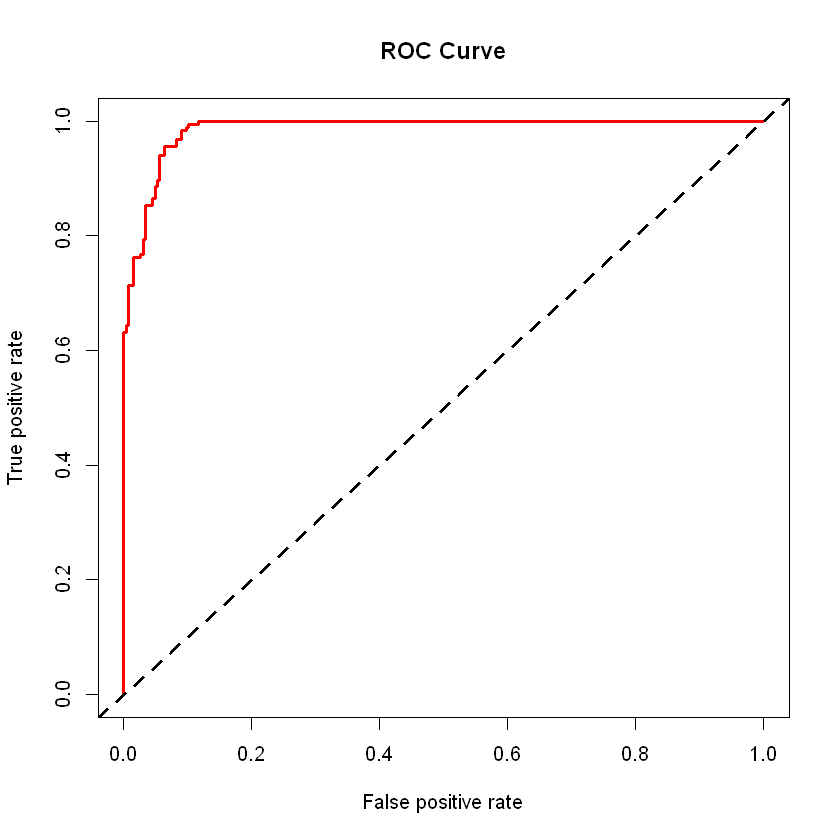

In [28]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wesbrook_pred, wesbrook_test$WESBROOK)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Predykcja wartosci prawdopodobienstw
wesbrook_pred_p <- predict(wesbrook_mod, wesbrook_test, type = "prob")
head(wesbrook_pred_p)

roc_pred <-
  prediction(
    predictions = wesbrook_pred_p[, "Y"],
    labels = wesbrook_test$WESBROOK
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wesbrook_auc <- unlist(slot(auc_perf,"y.values"))
wesbrook_auc


In [29]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
cv_control <- trainControl(method = "cv", number = 10)
wesbrook_mod_cv <- train(
  WESBROOK ~ .,
  data = wesbrook_train,
  method = "xgbTree",
  metric = "Accuracy",
  trControl = cv_control,
  tuneGrid = expand.grid(
    nrounds = 100,
    max_depth = 6,
    eta = 0.3,
    gamma = 0.01,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample = 1
  )
)
print(wesbrook_mod_cv)

### Walidacja krzyzowa losowa
random_control <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
wesbrook_mod_random <- train(
  WESBROOK ~ .,
  data = wesbrook_train,
  method = "xgbTree",
  metric = "Accuracy",
  trControl = random_control,
  tuneGrid = expand.grid(
    nrounds = 100,
    max_depth = 6,
    eta = 0.3,
    gamma = 0.01,
    colsample_bytree = 1,
    min_child_weight = 1,
    subsample = 1
  )
)
print(wesbrook_mod_random)


eXtreme Gradient Boosting 

1356 samples
  26 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1221, 1220, 1220, 1221, 1220, 1221, ... 
Resampling results:

  Accuracy  Kappa    
  0.947598  0.8923239

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1
eXtreme Gradient Boosting 

1356 samples
  26 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1220, 1220, 1221, 1220, 1221, 1220, ... 
Resampling results:

  Accuracy   Kappa    
  0.9483588  0.8937876

Tuning parameter 'nrounds' was held constant at a value of 100
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1


In [30]:
##################################
# 6. Metoda SVM                  #
##################################

In [31]:
# -------------------- #
# Przygotowanie danych #
# -------------------- #

# Usuniecie obiektow dla czystego startu nastepnego modelu
rm(list = setdiff(ls(), "Wesbrook_backup"))

# Przywrocenie zbioru z kopii
Wesbrook <- Wesbrook_backup

###  Podzial zbioru na treningowy i testowy w proporcjach 75% do 25%

set.seed(1234)
sample_index <-
  sample(nrow(Wesbrook), round(nrow(Wesbrook) * .75), replace = FALSE)
wesbrook_train <- Wesbrook[sample_index,]
wesbrook_test <- Wesbrook[-sample_index,]

# Sprawdzenie proporcji klas dla wszystkich trzech zbiorow
round(prop.table(table(select(Wesbrook, WESBROOK))),2)
round(prop.table(table(select(wesbrook_train, WESBROOK))),2)
round(prop.table(table(select(wesbrook_test, WESBROOK))),2)


WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

WESBROOK
   Y    N 
0.41 0.59 

In [32]:
# ---------------- #
# Tworzenie modelu #
# ---------------- #

# Budowa modelu za pomoca funkcji randomForest() z pakietu randomForest
wesbrook_mod <- svm(WESBROOK ~ ., data = wesbrook_train, probability=TRUE)
print(wesbrook_mod)

wesbrook_pred <- predict(wesbrook_mod, wesbrook_test, type = "class")



Call:
svm(formula = WESBROOK ~ ., data = wesbrook_train, probability = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  791



Confusion Matrix and Statistics

          Reference
Prediction   Y   N
         Y 114  22
         N  71 245
                                         
               Accuracy : 0.7942         
                 95% CI : (0.754, 0.8306)
    No Information Rate : 0.5907         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.5565         
                                         
 Mcnemar's Test P-Value : 6.445e-07      
                                         
            Sensitivity : 0.6162         
            Specificity : 0.9176         
         Pos Pred Value : 0.8382         
         Neg Pred Value : 0.7753         
             Prevalence : 0.4093         
         Detection Rate : 0.2522         
   Detection Prevalence : 0.3009         
      Balanced Accuracy : 0.7669         
                                         
       'Positive' Class : Y              
                                         

,N,Y
1,5.626091e-05,0.9999437
2,2.394538e-04,0.9997605
3,1.105061e-02,0.9889494
4,1.109508e-01,0.8890492


[1] 0.8910821

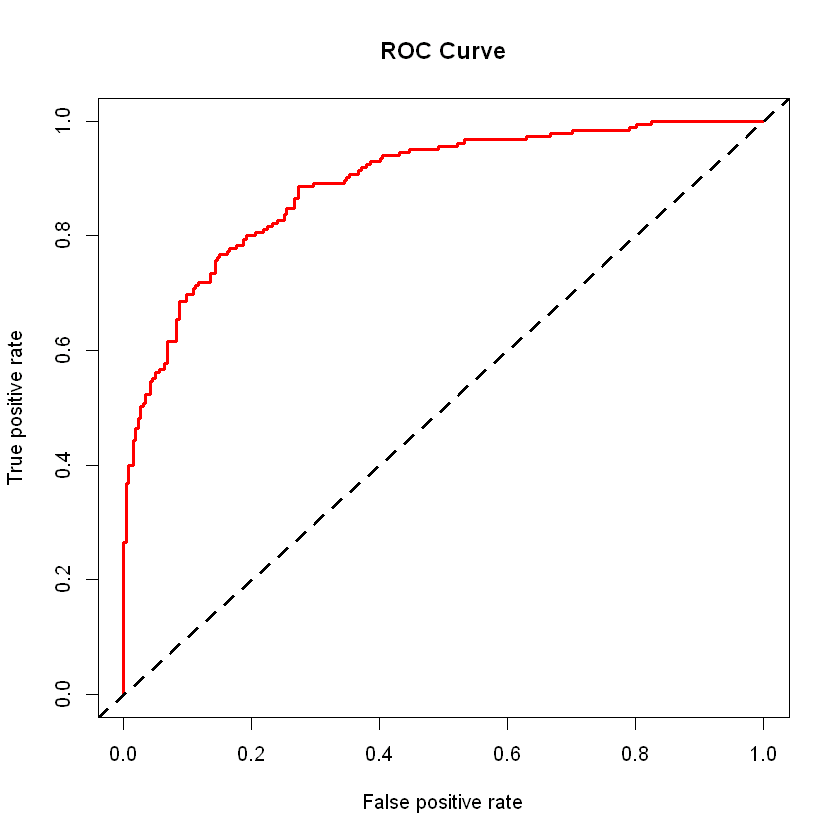

In [33]:
# ---------------- #
# Ewaluacja modelu #
# ---------------- #

### 1. Ewaluacja z wykorzystaniem macierzy pomylek
confusionMatrix(wesbrook_pred, wesbrook_test$WESBROOK)

### 2. Ewaluacja z wykorzystaniem krzywej ROC

# Predykcja wartosci , wazne aby ustawic parametry : 
# decision.values = TRUE, probability = TRUE
wesbrook_pred <- predict(wesbrook_mod, wesbrook_test, decision.values = TRUE, probability = TRUE)

# Wyodrebnianie prawdopodobienstw
attr(wesbrook_pred, "probabilities")[1:4,]

wesbrook_pred_p <- attr(wesbrook_pred, "probabilities")

roc_pred <-
  prediction(
    predictions = wesbrook_pred_p[, "Y"],
    labels = wesbrook_test$WESBROOK
  )

roc_perf <- performance(roc_pred, measure = "tpr", x.measure = "fpr")

plot(roc_perf, main = "ROC Curve", col = "red", lwd = 3)
abline(a = 0, b = 1, lwd = 3, lty = 2, col = 1)

### 3. Ewaluacja z wykorzystaniem wspolczynnika AUC

# Wygenerowanie obiektu wydajnosci z parametrem measure = "auc"
auc_perf <- performance(roc_pred, measure = "auc")

# Wydobycie wartosci y.values ze slotu z obiektu auc_perf
wesbrook_auc <- unlist(slot(auc_perf,"y.values"))
wesbrook_auc


In [34]:
# ---------------- #
# Walidacja modelu #
# ---------------- #

### Walidacja krzyzowa k-krotna
ctrl <- trainControl(method = "cv", number = 10)
wesbrook_cv_mod <- train(WESBROOK ~ ., data = wesbrook_train, method = "svmRadial", trControl = ctrl, probability = TRUE)
print(wesbrook_cv_mod)

### Walidacja krzyzowa losowa
ctrl_random <- trainControl(method = "LGOCV", number = 10)
wesbrook_random_mod <- train(WESBROOK ~ ., data = wesbrook_train, method = "svmRadial", trControl = ctrl_random, probability = TRUE)
print(wesbrook_random_mod)

Support Vector Machines with Radial Basis Function Kernel 

1356 samples
  26 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1220, 1221, 1221, 1220, 1220, 1220, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.6902996  0.3317840
  0.50  0.7050599  0.3618937
  1.00  0.7264161  0.4119449

Tuning parameter 'sigma' was held constant at a value of 4.71925e-11
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 4.71925e-11 and C = 1.
Support Vector Machines with Radial Basis Function Kernel 

1356 samples
  26 predictor
   2 classes: 'Y', 'N' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (10 reps, 75%) 
Summary of sample sizes: 1018, 1018, 1018, 1018, 1018, 1018, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.6967456  0.3445924
  0.50  0.7014793  0.35

In [35]:
###########
# WNIOSKI #
###########

In [ ]:
### 1. K-najblizszych sąsiadów

# Dokładność (macierz pomylek): 70%
# Krzywwa ROC:
# - Powyżej linii losowości - zdolnośc klasyfikowania lepsza niż losowa
# - Brak pełnego wygięcia do górnego lewego rogu - model nie jest idealny
# Dokładność (walidacja k-krotna): 74%
# Dokładność (walidacja losowa): 72%

# Podsumowanie: model ma umiarkowaną skuteczność

In [ ]:
### 2. Naiwny klasyfikator Bayesa

# Dokładność (macierz pomylek): 83%
# Krzywwa ROC:
# - Powyżej linii losowości - zdolnośc klasyfikowania lepsza niż losowa
# - Mocniejsze wygięcie do górnego lewego rogu - model nie jest idealny, ale jest dość dobry
# Dokładność (walidacja k-krotna): 55%
# Dokładność (walidacja losowa): 87%

# Podsumowanie: odel ma umiarkowanie dobrą skuteczność, walidacja k-krotna była zbyt krótka

In [ ]:
### 3. Drzew klasyfikacyjnych

# Dokładność (macierz pomylek): 94%
# Krzywwa ROC:
# - Powyżej linii losowości - zdolnośc klasyfikowania lepsza niż losowa
# - Bardzo ostre wygięcie do górnego lewego rogo - bardzo dobry model
# Dokładność (walidacja k-krotna): 94%
# Dokładność (walidacja losowa): 94%

# Podsumowanie: model jest bardzo dobry, osiaga duza skutecznosc odpowiedzi

In [ ]:
### 4. Lasow Losowych (Random Forest)

# Dokładność (macierz pomylek): 94%
# Krzywwa ROC:
# - Powyżej linii losowości - zdolnośc klasyfikowania lepsza niż losowa
# - Bardzo ostre wygięcie do górnego lewego rogo - dobry model
# Dokładność (walidacja k-krotna): 92%
# Dokładność (walidacja losowa): 93%

# Podsumowanie: model jest bardzo dobry, osiaga duza skutecznosc odpowiedzi

In [ ]:
### 5. Algorytmu XGBoost

# Dokładność (macierz pomylek): 94%
# Krzywwa ROC:
# - Powyżej linii losowości - zdolnośc klasyfikowania lepsza niż losowa
# - Bardzo ostre wygięcie do górnego lewego rogo - dobry model
# Dokładność (walidacja k-krotna): 94%
# Dokładność (walidacja losowa): 94%

# Podsumowanie: model jest bardzo dobry, osiaga duza skutecznosc odpowiedzi


In [ ]:
### 6. Metody SVM

# Dokładność (macierz pomylek): 79%
# Krzywwa ROC:
# - Powyżej linii losowości - zdolnośc klasyfikowania lepsza niż losowa
# - Brak pełnego wygięcia do górnego lewego rogu - model jest umiarkowanie dobry
# Dokładność (walidacja k-krotna): 70%
# Dokładność (walidacja losowa): 70%

# Podsumowanie: model jest umiarkowanie dobry

In [ ]:
### Podsumowanie ćwiczenia

# W ramach ćwiczenia udało się stworzyć 6 różnych modeli klasyfikacyjnych.
# Modele K-najbliższych sąsiadów (KNN) oraz Metody SVN osiągnęły mniejszą
# skuteczność niż pozostałe, ponieważ KNN sprawdza się lepiej dla małych
# zbiorów danych, a SVN dla dobrze zbalansowanych. Modele Random Forest oraz
# XGBoost mają lepszą zdolność generalizacji oraz odporność na problem
# niezbalansowanych danych.Naiwny klasyfikator Bayesa miał przeciętną skuteczność
# w porównaniu z pozostałymi modelami, wynika to tego, że jest to prosty model z
# prostymi założeniami. Drzewa klasyfikacyjne mają bardzo precyzyjny wzrost
# skuteczności oraz również osiągnął dużą skuteczność.

# Do analizy modeli wykorzystano skuteczne narzędzia statystyczne takie jak wykres
# krzywej ROC, współczynnik AUC oraz macierz pomyłek. Pozwoliły one na precyzyjną
# ewaluację modeli. Dodatkowo udało się skutecznie przeprowadzić walidację krzyżową
# k-krotną oraz losową, których wyniki potwierdziły poprawność ewaluacji modelu.